### Mount google drive



In [1]:
# comment these lines if on local machine
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing required libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re

#from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#### Function definitions

In [0]:
# converts the string which can be converted into float (eg. '0.81')
def convert_str_to_float(value):
  try:
    return float(value)
  except:
    return value


# parsing unstructured data 
def preprocessing(input_file_path=None, output_file_path=None):
  with open(input_file_path) as input_file:
    output_list = []
    count = 0
    for line in input_file.read().split():
      count=count+1
      line = re.sub('[" .]','',line)  # regex to replace " and . to null
      line = re.sub(r',','.',line)  # regex to replace , with . to represent floating point values

      line = [convert_str_to_float(cell) for cell in line.split(';')] # parsing numerical values

      output_list.append(line)
      
    output_df = pd.DataFrame(output_list[1:], columns=output_list[0])

    output_df.to_csv(output_file_path, index=None, header=True)
    
    print(f'{count} files processed')


# converting categorical values to numerical values
def convert_categorical_to_numerical(column):
  enc = LabelEncoder()
  if column.dtype=='O':
    column = enc.fit_transform(column)
  return column

### Data parsing

In [0]:
train_file_src_path = "drive/My Drive/Colab Notebooks/Leapfrog/Data/training.csv"
train_file_dst_path = "drive/My Drive/Colab Notebooks/Leapfrog/Data/processed_training.csv"
test_file_src_path = "drive/My Drive/Colab Notebooks/Leapfrog/Data/validation.csv"
test_file_dst_path = "drive/My Drive/Colab Notebooks/Leapfrog/Data/processed_validation.csv"

In [5]:
preprocessing(train_file_src_path, train_file_dst_path)
preprocessing(test_file_src_path, test_file_dst_path)

3701 files processed
201 files processed


* **Load training and testing data**

In [6]:
processed_train_file_path = "drive/My Drive/Colab Notebooks/Leapfrog/Data/processed_training.csv"

train_df  = pd.read_csv(processed_train_file_path)
train_df.head(2)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,a,17.92,0.000054,u,-0.840182,0.522883,1.75,f,t,1.0,t,g,80.0,5.0,800000.0,t,0.0,no
1,b,16.92,0.000034,y,-2.159635,0.774187,0.29,f,f,0.0,f,s,200.0,0.0,2000000.0,NaN,0.0,no


In [7]:
processed_test_file_path = "drive/My Drive/Colab Notebooks/Leapfrog/Data/processed_validation.csv"

test_df  = pd.read_csv(processed_test_file_path)
test_df.head(2)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,b,32.33,0.000750,u,0.840107,0.544982,1.585,t,f,0.0,t,s,420.0,0.0,4200000.0,NaN,1.0,no
1,b,23.58,0.000179,u,-4.174396,0.864362,0.540,f,f,0.0,t,g,136.0,1.0,1360000.0,NaN,0.0,no


#### Data preprocessing

The  code below shows the count of missing values for all the features
```
count_nan = len(train_df) - train_df.count()
count_nan
```
---

From  the result it is found that the attribute v16 has 2145 values missing from total 3701 instances.

*Hence we do not consider this attribute for creating classification model.*

---
* **Removing column v16 from dataframe**


In [0]:
train_df = train_df.drop(['v16'], axis=1)
test_df = test_df.drop(['v16'], axis=1)

* **Removing instances with missing values**



In [0]:
train_df = train_df.dropna()
test_df = test_df.dropna()

* **Converting attribute with categorical values to numerical values**

In [0]:
#saving categorical label
train_label = train_df.iloc[:,-1]
test_label = test_df.iloc[:,-1]

train_df = train_df.apply(lambda x: convert_categorical_to_numerical(x), axis=0)
test_df = test_df.apply(lambda x: convert_categorical_to_numerical(x), axis=0)

In [11]:
train_df.head(2)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,classLabel
0,0,17.92,0.000054,1,-0.840182,0.522883,1.75,0,1,1.0,1,0,80.0,5.0,800000.0,0.0,0
1,1,16.92,0.000034,2,-2.159635,0.774187,0.29,0,0,0.0,0,2,200.0,0.0,2000000.0,0.0,0


* **Attributes correlation plot for feature selection**

[]

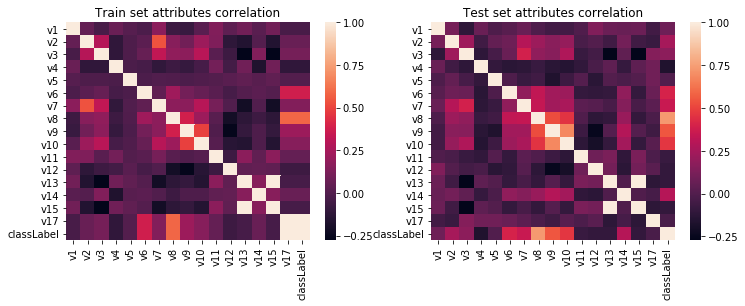

In [12]:
plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)
ax1.title.set_text("Train set attributes correlation")
sns.heatmap(train_df.corr(), ax=ax1)

ax2 = plt.subplot(1,2,2)
ax2.title.set_text("Test set attributes correlation")
sns.heatmap(test_df.corr(), ax=ax2)

plt.plot()

* From the above plot we can see that the attributes v17 and classLabel are perfectly correlated with correlation coefficient of 1 which signifies that both are same attribute.
> This attribute v17 can be considered as the ultimate predictor for classLabel. But with this two cases are possible,
  1.   The real data also have the same pattern and this is something we have no idea of
  2.   The real data do not have the same pattern (Also seen from test data)
  >
Looking at scenario it is better to just discard this feature, also because this feature will put other significant attributes under shadow.

*  Also v13 and v15 are perfectly correlated
---
*Hence we donot consider feature v15 and v17*

---

* **Removing features v15 and v17**

In [0]:
train_df = train_df.drop(['v15', 'v17'], axis=1)
test_df = test_df.drop(['v15', 'v17'], axis=1)

* **Standarizing dataframe so that the the attribute values follow its own distribution**

    *Also different statistical analysis can be performed like data deviation, outlier*

In [0]:
std = StandardScaler()

train_df = pd.DataFrame(std.fit_transform(train_df), columns=train_df.columns)
test_df = pd.DataFrame(std.transform(test_df), columns=test_df.columns)

* **Split df to X and y**

In [0]:
X_train = train_df.iloc[:,:-1]
y_train = train_label

X_test = test_df.iloc[:,:-1]
y_test = test_label

#### Model Selection

Model was selected doing a grid search over various combination of parameters and for randomforest, extratree and SVC

In [16]:
# the given training dataset is highly imbalanced
# hence class_weight parameter of model is set to balanced to give unequal weight to different class
model= SVC(kernel='sigmoid',C=1,class_weight='balanced')
model.fit(X_train,y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
# test data prediction
y_pred = model.predict(X_test)

#### Different metric analysis for model

* **Accuracy**

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : {0:.2f} %".format(accuracy*100))

Accuracy : 84.82 %


* **Confusion matrix**

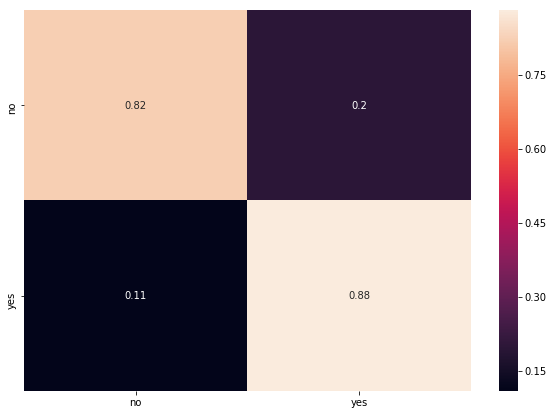

In [19]:
conf_matrix = confusion_matrix(convert_categorical_to_numerical(y_test),
                               convert_categorical_to_numerical(y_pred))
total = np.sum(conf_matrix, axis=1)
conf_matrix = np.round(conf_matrix/total,2)

df_cm = pd.DataFrame(conf_matrix, index = ['no', 'yes'],
                  columns = ['no', 'yes'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

* **Classification report**

In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          no       0.88      0.82      0.85        99
         yes       0.82      0.88      0.85        92

    accuracy                           0.85       191
   macro avg       0.85      0.85      0.85       191
weighted avg       0.85      0.85      0.85       191



### Conclusion

**Neural network was als tested but the accuracy was only small increase i.e. 86% with higher uncertainity to replicate the same result.**

---
Hence svm model with sigmoid kernel was choosen as final classification model.

---